In [449]:
import nfldb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib import cm


%matplotlib inline

In [3]:
db = nfldb.connect()

In [4]:
# Offense

# Rushing yards made=0.1pts
# Rushing touchdowns=6pts
# Passing yards=0.04pts
# Passing touchdowns=4pts
# Interceptions=-1pt
# Receiving yards=0.1pts
# Receiving touchdowns=6pts
# Receptions=0.5pts
# Kickoff return touchdowns=6pts
# Punt return touchdowns=6pts
# Fumbles lost=-2pts
# Own fumbles recovered touchdowns=6pts
# Two-point conversions scored=2pts
# Two-point conversion passes=2pts
# Field-goals from 0-39 yards=3pts
# Field-goals from 40-49 yards=4pts
# Field-goals from 50+ yards=5pts
# Extra-point conversions=1pt

# ------------------------
# Defense

# Sacks=1pt
# Opponent-fumbles recovered=2pts
# Return touchdowns=6pts
# Extra Point Return=2pts
# Safeties=2pts
# Blocked Punt/Kick=2pts
# Interceptions made=2pts
# 0 points allowed=10pts
# 1-6 points allowed=7pts
# 7-13 points allowed=4pts
# 14-20 points allowed=1pt
# 21-27 points allowed=0pts
# 28-34 points allowed=-1pt
# 35+ points allowed=-4pts

In [5]:
FD_off_scoring = [.1, 6, .04, 4, -1, .1, 6, 
                  .5, 0, 6, 6, -2, 6, 
                  0, 2, 0, 2, 0, 2, 
                  3
                  #just giving all FG's a 3 for now. Distance to come later
                    , 0, 0, 0, 1]
off_stats=['rushing_yds','rushing_tds','passing_yds','passing_tds','passing_int','receiving_yds','receiving_tds',
              'receiving_rec','receiving_tar','kickret_tds','puntret_tds','fumbles_lost','fumbles_rec_tds',
              'passing_twopta','passing_twoptm','rushing_twopta','rushing_twoptm','receiving_twopta','receiving_twoptm',
              'kicking_fgm','kicking_fgmissed','kicking_fgm_yds','kicking_fgmissed_yds','kicking_xpmade']
FD_def_scoring = [1,2,6,2,2,2,2,
                    2]
def_stats = ['defense_sk','fumbles_rec','defense_tds','defense_safe','defense_fgblk','defense_xptblk','defense_puntblk',
            'defense_int',#### Points problem
            ]

In [6]:
def get_player_details(year, week):
    all_players = {}
    q = nfldb.Query(db)
    q.game(season_year=year, season_type='Regular',week=week)
    games = q.as_games()
    for g in games:
        teams = [g.away_team, g.home_team]
        for team, p in g.players:
            player_details = {}
            player_details['team'] = team
            player_details['position'] = str(p.position)
            player_details['opponent'] = teams[0] if teams[0]!=team else teams[1]
            all_players[p.full_name] = player_details
    df = pd.DataFrame(all_players).T
    return df

In [7]:
def get_off_yearweek_scoring(year, week):
    all_players = {}
    db = nfldb.connect()
    q = nfldb.Query(db)
    q.game(season_year=year, season_type='Regular',week=week)
    for pp in q.sort('passing_tds').as_aggregate():
        player_stats = {}
        for stat in off_stats:
            player_stats[stat] = getattr(pp,stat)
        all_players[pp.player.full_name] = player_stats
    df = pd.DataFrame(all_players).T[off_stats]*FD_off_scoring
#     df['f_score'] = df[off_stats]*FD_off_scoring
    df['week'] = week
    df['year'] = year
    
    ### GET PLAYER INFO
    player_details = get_player_details(year, week)
    df = df.join(player_details)
    
    return df

In [8]:
df = pd.DataFrame()
for year in range(2013,2019):
    for week in range(1,18):
        df = df.append(get_off_yearweek_scoring(year, week))

In [9]:
df_g = df.reset_index().groupby(['index','year','week','team','position','opponent']).sum()

In [10]:
df_g['f_score'] = df_g.sum(axis=1)

In [166]:
plotting = df_g[['f_score']].reset_index().groupby(['index']).agg({'f_score':['mean','median','std','count']})['f_score']

# Plots
___
### Heat maps -> (x: mean/median, y: std, count) by position

In [59]:
x = 'mean'
y = 'std'

filt = True

Text(0,0.5,'std')

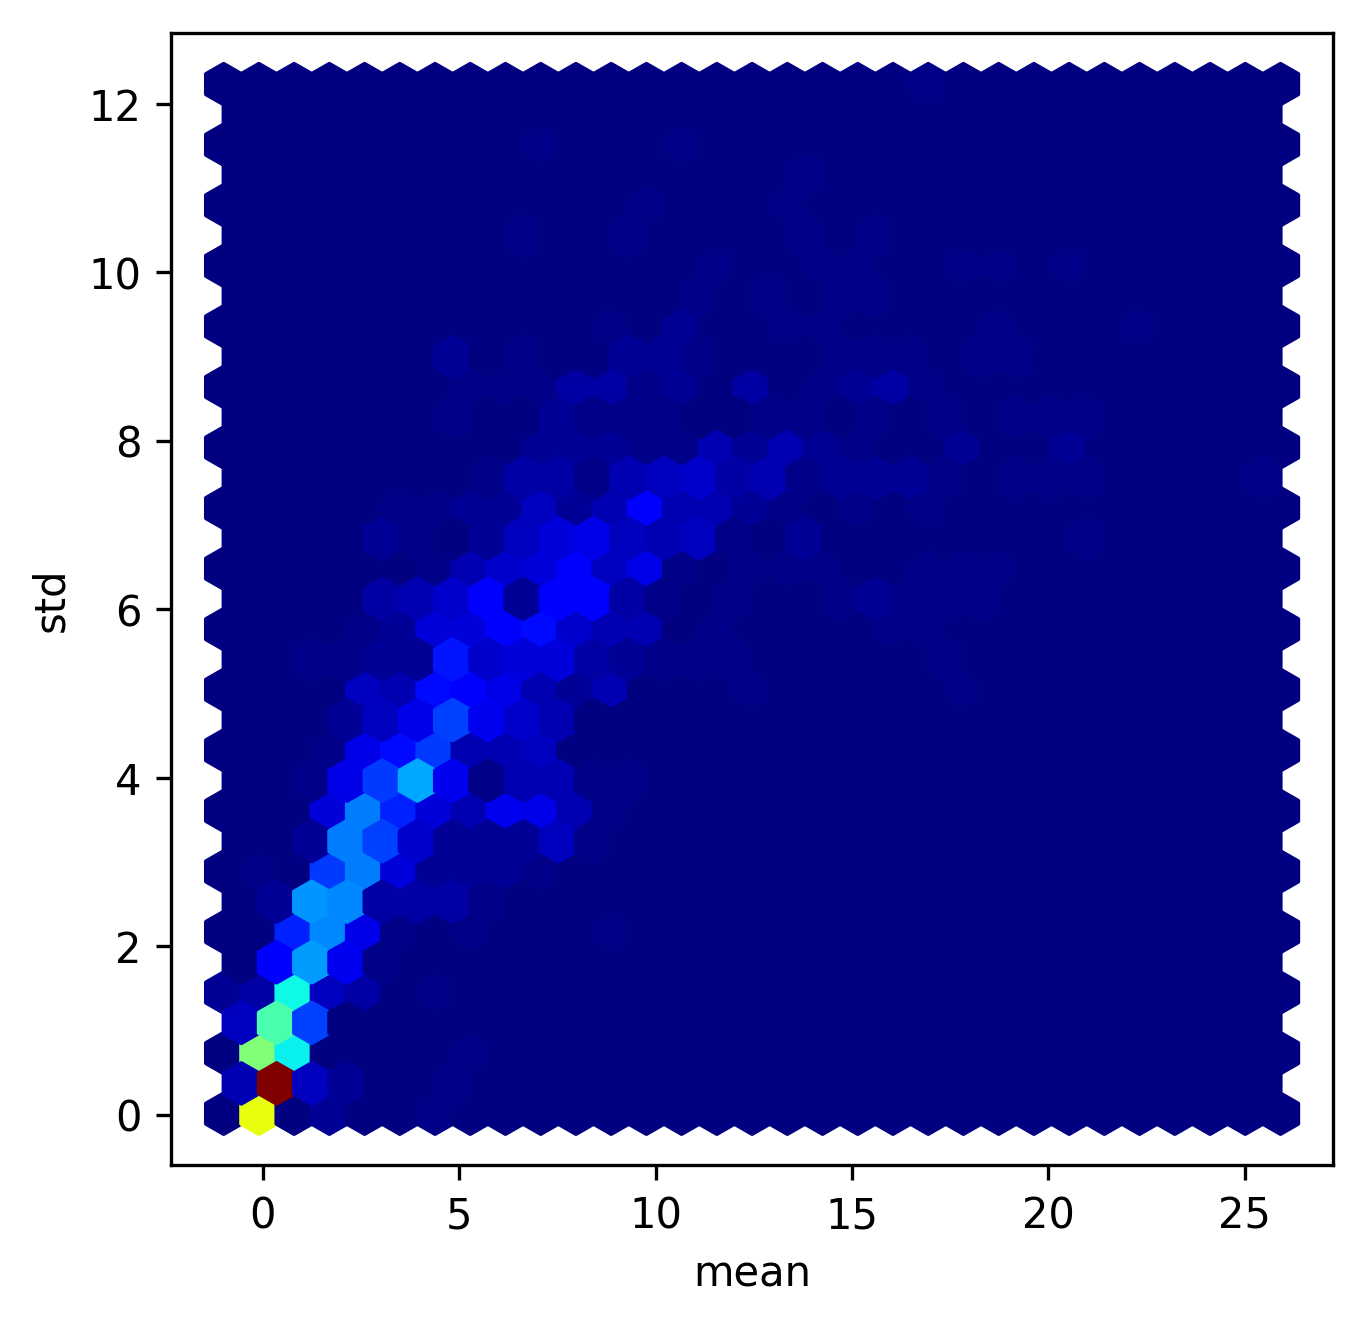

In [168]:
fig, ax1 = plt.subplots(1,1, figsize=(5,5), dpi=300)
if filt:
    plot = plotting[(plotting[x]!=0)&(plotting[y]!=0)]
else:
    plot = plotting
ax1.hexbin(plot[x], 
           plot[y], 
           C=None, 
           gridsize=30,
           cmap='jet')
ax1.set_xlabel(x)
ax1.set_ylabel(y)

## Positional

In [16]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt


In [481]:
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,#st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy]
    

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for i, distribution in enumerate(DISTRIBUTIONS):
        # Uncomment to print out progress
#         print(float(i)/len(DISTRIBUTIONS))

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass
    print('Best Dist: {}'.format(best_distribution.name))
    return (best_distribution, best_params)
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

def filter_data(name=slice(None), year=slice(None), week=slice(None), 
                team=slice(None), position=slice(None), opponent=slice(None)):
    in_pos = df_g.loc[(name, year, week, team, position, opponent),:]
#     print('Games recorded: {}'.format(len(in_pos)))

#     data = in_pos['f_score']
    data = in_pos[(in_pos['passing_yds'] >= 2.0) | 
                  (in_pos['rushing_yds'] >= 2.0) | 
                  (in_pos['receiving_yds'] >= 2.0)]['f_score']
#     bins = int(np.sqrt(len(data))) + 4

    return data
# {'WR':st.exponnorm,
# 'QB':st.gengamma,st.foldnorm,
# 'RB':st.exponnorm}
# dist, params = best_fit_distribution(data, bins=bins, ax=None)

In [358]:
players = set(df_g.reset_index()['index'])

for name in players:
    if 'Wins' in name:
        print(name)

Winston Justice
Glenn Winston
Jameis Winston
Eric Winston
Winston Guy
Kellen Winslow


In [354]:
name = slice(None)
year = slice(None)
week = slice(None)
team = slice(None)
position = 'RB'
opponent = 'NE'

In [54]:
pdf = make_pdf(dist, params, size=10000)
pdf1 = make_pdf(st.exponnorm,st.exponnorm.fit(data), size=10000)
pdf2 = make_pdf(st.foldnorm, st.foldnorm.fit(data), size=10000)
pdf3 = make_pdf(st.gengamma, st.gengamma.fit(data), size=10000)

X, y = pdf.index, pdf.values

fig, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.plot(pdf.index, pdf.values, lw=2.0, ls='--', label='measured')
ax1.plot(pdf1.index, pdf1.values, lw=2.0, label='exponnorm')
# ax1.plot(pdf2.index, pdf2.values, lw=2.0, label='foldnorm')
ax1.plot(pdf3.index, pdf3.values, lw=2.0, label='gengamma')
ax2 = ax1.twinx()
ax2.hist(data, bins=bins, alpha=.2)
ax1.legend()

NameError: name 'dist' is not defined

## Make Player Predictions
___
### Older Version


    Pred Points: 13.26
    Lower Bound: 7.55
    Upper Bound: 20.3
    


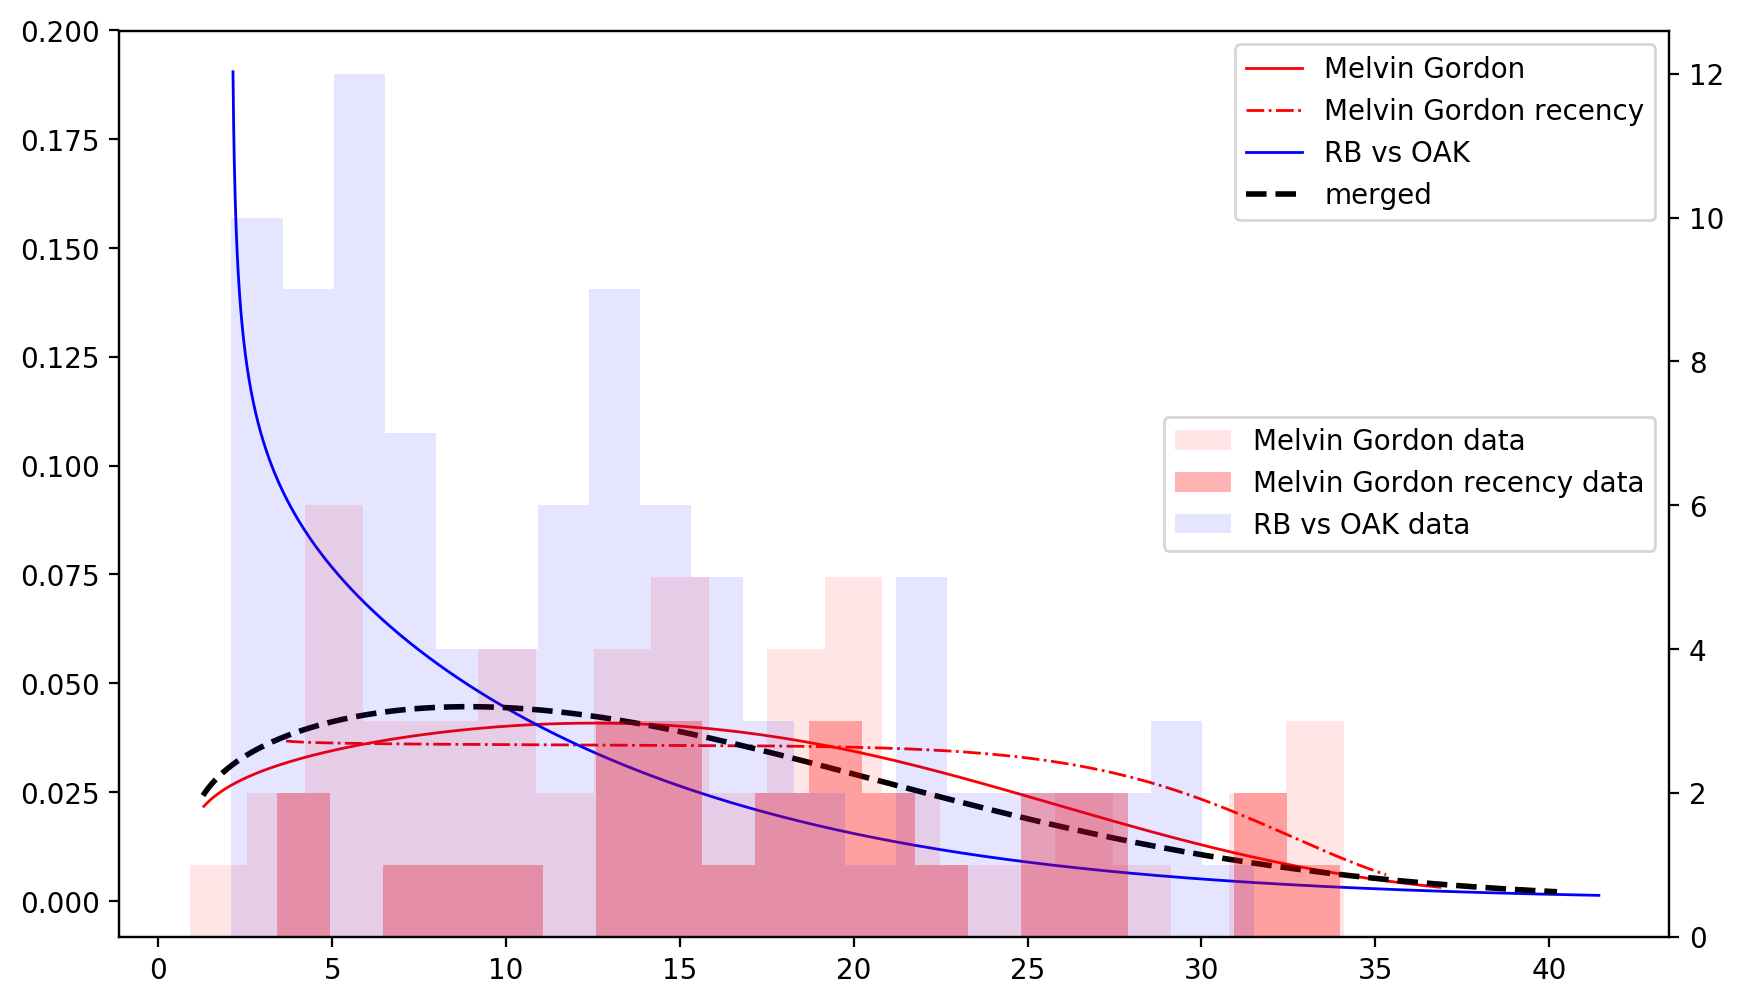

In [482]:
def make_pred_curve(name, opponent, position, year, dist_=st.gengamma):
    p1_p = dist_.fit(filter_data(name=name))
    p2_p = dist_.fit(filter_data(name=name, year=year))
    p3_p = dist_.fit(filter_data(opponent=opponent,position=position))

    p1 = dist_.rvs(*p1_p[:-2], loc=p1_p[-2], scale=p1_p[-1], size=10000)
    p2 = dist_.rvs(*p2_p[:-2], loc=p2_p[-2], scale=p2_p[-1], size=10000)
    p3 = dist_.rvs(*p3_p[:-2], loc=p3_p[-2], scale=p3_p[-1], size=10000)
    #### MAKE MASTER
    pm_p = dist_.fit(np.concatenate((p1, p2, p3)))

    pdf_name = make_pdf(dist_, p1_p, size=10000)
    pdf_namerecent = make_pdf(dist_, p2_p, size=10000)
    pdf_opponent = make_pdf(dist_, p3_p, size=10000)
    pdf_master = make_pdf(dist_, pm_p, size=10000)

    fig, ax1 = plt.subplots(1,1, figsize=(10,6), dpi=200)
    
    ax1.plot(pdf_name.index, pdf_name.values, lw=1.0, label=f'{name}', color='red')
    ax1.plot(pdf_namerecent.index, 
             pdf_namerecent.values, 
             lw=1.0, 
             ls='-.', 
             label=f'{name} recency', 
             color='red')
    ax1.plot(pdf_opponent.index, 
             pdf_opponent.values, 
             lw=1.0, 
             label=f'{position} vs {opponent}', 
             color='blue')
    ax1.plot(pdf_master.index, 
             pdf_master.values, 
             lw=2.0, 
             ls='--', 
             label='merged', 
             color='black')
    
    ax2 = ax1.twinx()
    ax2.hist(filter_data(name=name), 
             bins=20, 
             alpha=.1, 
             color='red', 
             label=f'{name} data')
    ax2.hist(filter_data(name=name, year=year), 
             bins=20, 
             alpha=.3, 
             color='red', 
             label=f'{name} recency data')
    ax2.hist(filter_data(opponent=opponent,position=position), 
             bins=20, 
             alpha=.1, 
             color='blue', 
             label=f'{position} vs {opponent} data')
    
    ax1.legend(loc=1)
    ax2.legend(loc=5)
    _25 = round(dist.ppf(0.25, *pm_p),2)
    _50 = round(dist.ppf(0.5, *pm_p),2)
    _75 = round(dist.ppf(0.75, *pm_p),2)

    pred_string = f"""
    Pred Points: {_50}
    Lower Bound: {_25}
    Upper Bound: {_75}
    """
    print(pred_string)
    return pm_p
name = "Melvin Gordon"
opponent = 'OAK'
position = 'RB'
year = [2017,2018]
dist = st.gengamma

pm_p = make_pred_curve(name, opponent, position, year, dist_=dist)

In [ ]:
name = "Melvin Gordon"
opponent = 'OAK'
position = 'RB'
year = [2017,2018]
dist = st.gengamma

pm_p = make_pred_curve(name, opponent, position, year, dist_=dist)

### Newer Version

In [483]:
def make_prediction(feature_set, dist_=st.gengamma, plot=False, readout=False):
    cum_rvs = np.array([])
    for pred_feature in feature_set:
        p_fit = dist_.fit(pred_feature['payload'])
        p_vals = dist_.rvs(*p_fit[:-2], loc=p_fit[-2], scale=p_fit[-1], size=10000)
        cum_rvs = np.concatenate((p_vals, cum_rvs))
        pred_feature['pdf'] = make_pdf(dist_, p_fit, size=10000)
    
    pm_p = dist_.fit(cum_rvs)
    feature_set.append({'label':'Prediction','pdf':make_pdf(dist_, pm_p, size=10000)})
    
    if plot:
        plot_feature_pred(feature_set)

    if readout:
        prediction_topline_readout(predictor_params=pm_p, dist=dist_)
        
    return pm_p
    
def prediction_topline_readout(predictor_params, dist):
    _25 = round(dist.ppf(0.25, *pm_p),2)
    _50 = round(dist.ppf(0.5, *pm_p),2)
    _75 = round(dist.ppf(0.75, *pm_p),2)
    _25_50 = int((_50-_25)/_50*100)
    _75_50 = int((_75-_50)/_50*100)

    pred_string = f"""
    Pred Points: {_50}
    Lower Bound: {_25} [{_25_50}%]
    Upper Bound: {_75} [{_75_50}%]
    """
    print(pred_string)
 
def plot_feature_pred(feature_set):
    fig, ax1 = plt.subplots(1,1, figsize=(10,6), dpi=200)
    ax2 = ax1.twinx()
    for feature in feature_set:
        plot_arg = {'ls':'--','lw':2.0, 'color':'black'} if feature['label'] == 'Prediction' else {'ls':'-'}
        ax1.plot(feature['pdf'].index, 
             feature['pdf'].values, 
             label=feature['label'],
             **plot_arg)
        try:
             ax2.hist(feature['payload'], 
             bins=20, 
             alpha=.1,
             label=feature['label'])
        except:
            pass
    ax1.legend(loc=1)
    ax2.legend(loc=5)


    Pred Points: 8.18
    Lower Bound: 5.05 [38%]
    Upper Bound: 12.59 [53%]
    


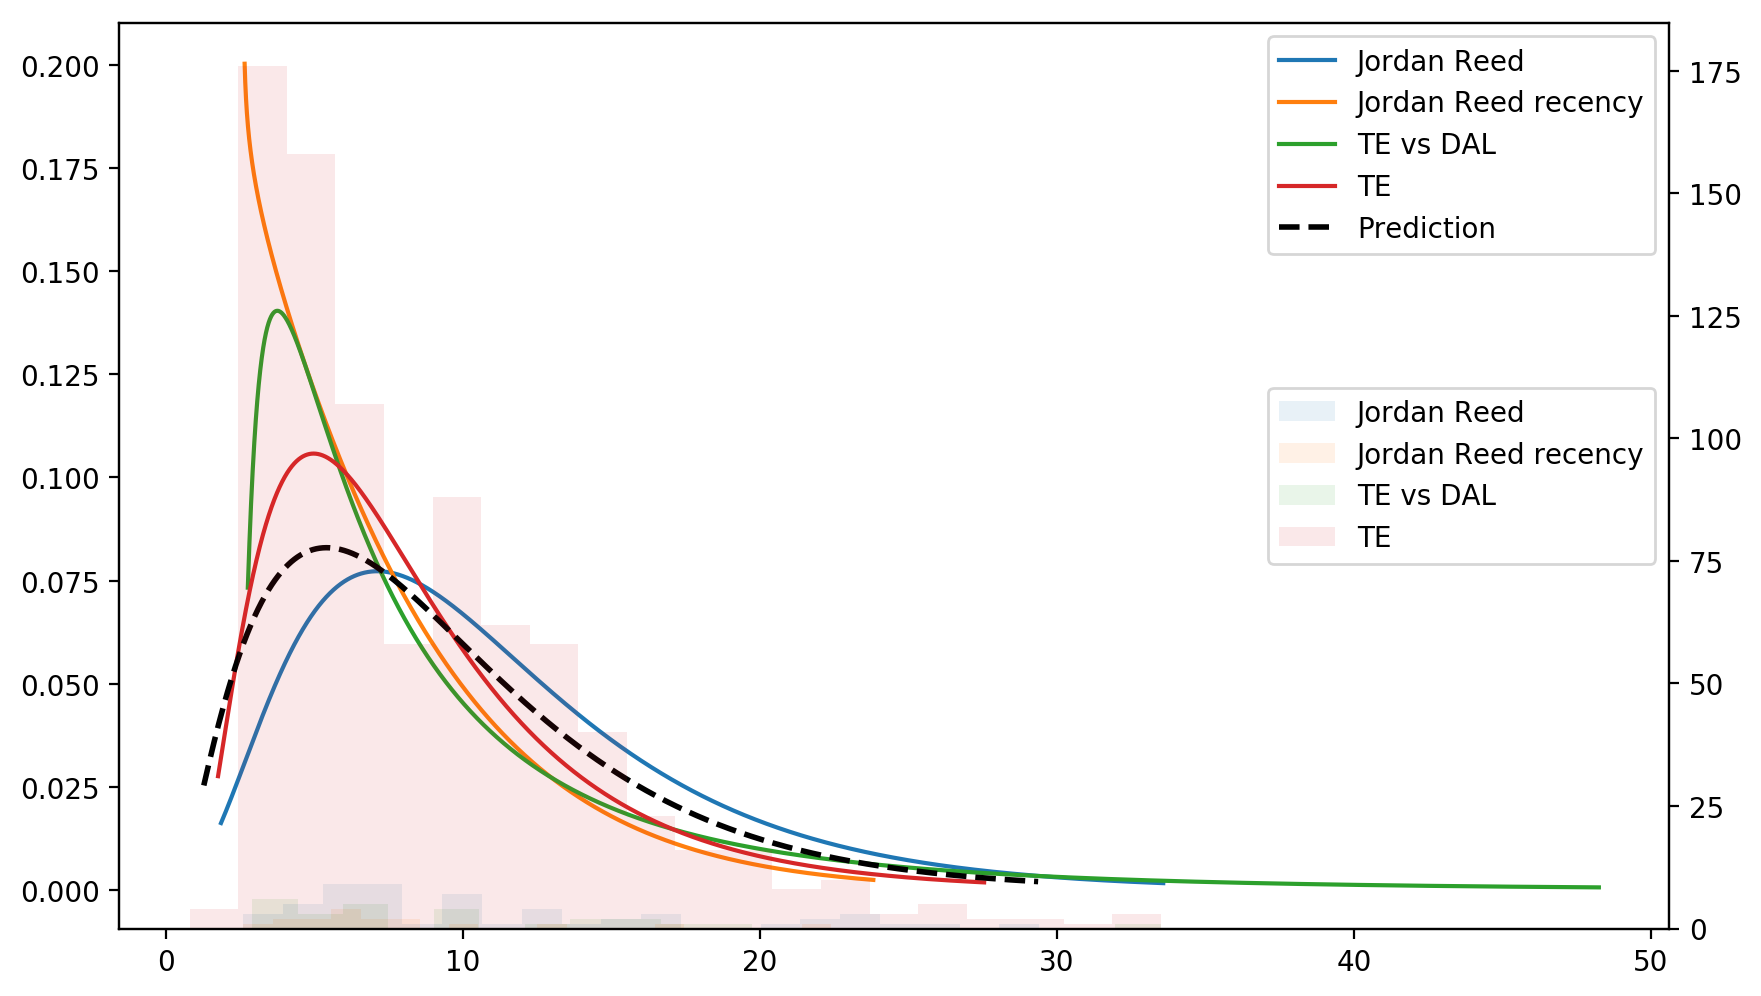

In [501]:
name = "Jordan Reed"
opponent = 'DAL'
position = 'TE'
year = [year for year in range(2017,2019)]
dist = st.gengamma

feature_set = [
    {'payload':filter_data(name=name),'label':name},
    {'payload':filter_data(name=name, year=year),'label':f'{name} recency'},
    {'payload':filter_data(opponent=opponent,position=position, year=year),'label':f'{position} vs {opponent}'},
    {'payload':filter_data(position=position, year=year),'label':f'{position}'},
]
pm_p = make_prediction(feature_set, dist_=dist, plot=True, readout=True)

## Scoring Distribution

In [359]:
r = df_g['f_score'].unstack(level=0)

In [360]:
r_ = (r-r.min())/(r.max()-r.min())

### Games Segmented

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



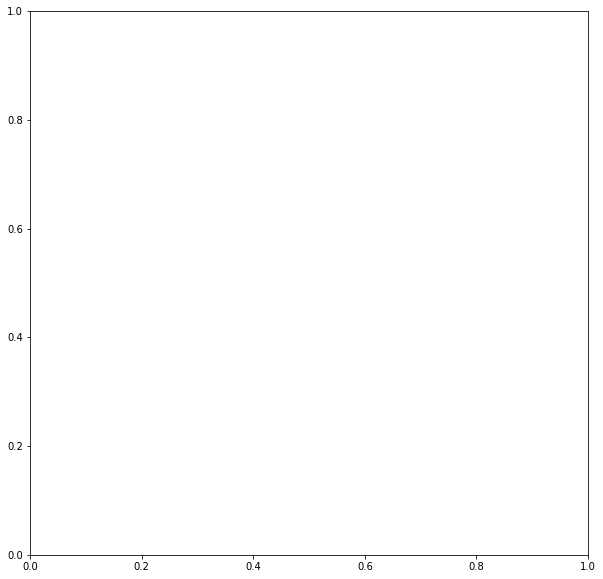

In [361]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
for game_lim in np.linspace(0,100,11):
    eligible_players = r_.T[(r_.notnull().sum() > game_lim)]
    score_set = eligible_players.stack([0,1]).values
    density = gaussian_kde(score_set[(score_set>0) & (score_set<1)])
    xs = np.linspace(0,1,500)
    density.covariance_factor = lambda : .1
    density._compute_covariance()
    ax1.plot(xs,density(xs), color=cm.gray_r((game_lim+100)/200), lw=5)

### Mean Segmented

In [ ]:
segments = 35
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
skipped = []
for mean_lim in np.linspace(0,r.mean().max()-1,segments):
    eligible_players = r_.T[(r.mean() > mean_lim) & (r.mean() < (mean_lim+r.mean().max()/segments))]
    if len(eligible_players) > 5:
        score_set = eligible_players.stack([0,1]).values
        density = gaussian_kde(score_set[(score_set>0) & (score_set<1)])
        xs = np.linspace(0,1,500)
        density.covariance_factor = lambda : .30
        density._compute_covariance()
        ax1.plot(xs,density(xs), color=cm.gray_r((mean_lim+r.mean().max()/10)/(r.mean().max())), lw=3)
    else:
        skipped.append(str(round(mean_lim,0)))
ax1.set_xlabel('Percentile of Individual Max Score')
ax1.set_ylabel('Density of Scores')
ax1.set_title('Scoring Distribution Segmented by Player Mean Score')
ax1.set_xlim(0,1)
print('Skipped Segments: {}\n'.format(','.join(skipped)))
# fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap='gray_r'), ax=ax1)

In [ ]:
player_tenure = 0
while player_tenure < 30:
    name = r.columns[np.random.randint(len(r.columns))]
    all_player = r[name].dropna().T.values
    player_tenure = all_player.sum()

bin_counts = {}
bins_ = np.linspace(all_player.min(), all_player.max(),10)
for bin_min, bin_max in zip(bins_[:-1], bins_[1:]):
    bin_counts[(bin_min+bin_max)/2] = len(all_player[(all_player >= bin_min) & (all_player < bin_max)])

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,6))

ax1.plot(bin_counts.keys(), bin_counts.values(), color='black', label='Score Distribution')
ax1.axvline(x=all_player.mean(), color = 'red', ls='--', label='Mean')
ax1.axvline(x=all_player.mean() + all_player.std(), color = 'pink', ls='--', label='+STD')
ax1.axvline(x=all_player.mean() - all_player.std(), color = 'pink', ls='--', label='-STD')
ax1.set_xlabel('Fantasy Score')
ax1.set_ylabel('Count of Scores')
ax1.set_title('Player Score Distribution')

r_w = r[name].dropna()
proj = (r_w.cumsum()/((r_w/r_w).cumsum())).fillna(method='ffill').values
real = r_w.dropna().values

ax2.scatter(real[:-1], proj[1:])
ax2.plot(range(0,int(r_w.max())),range(0,int(r_w.max())))
ax2.set_xlabel('Real Score')
ax2.set_ylabel('Proj Score')
ax2.set_title('Rolling Mean\nPrediction Efficency')
print(' \n\t\t\t\t\t{}'.format(name))

# Team ELO

In [ ]:
!cp /users/ryand/git/elo/elo.py ./
import elo

In [ ]:
db = nfldb.connect()
q = nfldb.Query(db)
q.game(season_year=2018, season_type='Regular')

In [ ]:
games_data = {}
for year in range(2013,2019):
    db = nfldb.connect()
    q = nfldb.Query(db)
    q.game(season_year=year, season_type='Regular')
    for g in q.as_games():
        games_data.update({g.gsis_id:{'home_team':g.home_team,
                                        'home_score':g.home_score,
                                        'away_team':g.away_team,
                                        'away_score':g.away_score,
                                        'winner':'home' if g.home_score > g.away_score else 'away',
                                        'week':g.week,
                                     'year':year}})

games_df = pd.DataFrame(games_data).T
for col in ['home_team','away_team']:
    games_df[col].replace('UNK','LAC', inplace=True)

In [ ]:
def run_elo(games_df):
    for game in games_df.index:
        winner = games_df.loc[game, 'winner']
        loser = 'away' if winner == 'home' else 'home'

        team_elo.do_competition(winner=games_df.loc[game, '{}_team'.format(winner)],
                                loser=games_df.loc[game, '{}_team'.format(loser)],
                                scoring={'win_score':games_df.loc[game,"{}_score".format(winner)],
                                         'lose_score':games_df.loc[game,"{}_score".format(loser)]}
                               )
    elo_results = pd.DataFrame(team_elo.EM.member_elo_cache, index=['ELO']).T.reset_index().rename(columns={'index':'team'})
    return elo_results

In [ ]:
teams = list(set(games_df['home_team'].tolist() + games_df['away_team'].tolist()))
team_elo = elo.ELO(K=90, score_div_factor=4, reset_factor=5, member_list=teams)
elo_progression = pd.DataFrame()
for year in range(2013,2019):
    for week in range(1,18):
        new_elo_scores = run_elo(games_df[(games_df['year']==year) & (games_df['week'] == week)])
        new_elo_scores['year'] = year
        new_elo_scores['week'] = week
        elo_progression = elo_progression.append(new_elo_scores)
    team_elo.season_reset()

In [ ]:
df_g_ = df_g.reset_index()
df_g_['team'].replace('UNK','LAC', inplace=True)

In [ ]:
df_elo = df_g_.merge(
    elo_progression, on=['team','week','year'], how='left').merge(
    elo_progression, left_on=['opponent','week','year'], right_on=['team','week','year'], how='left', suffixes=('_playerteam', '_opponent'))

In [ ]:
defe = df_elo.groupby(['team_opponent','year','week']).sum()

In [ ]:
defe['passing success'] = defe['receiving_rec']/defe['receiving_rec']

In [ ]:
defe[['receiving_rec','passing_tds']]

In [ ]:
o = df_elo[['index','year','week','team_playerteam','position','team_opponent','f_score','ELO_playerteam','ELO_opponent']].copy()

In [ ]:
o['ELO_diff'] = o['ELO_playerteam']-o['ELO_opponent']
o['ELO_rat'] = ((o['ELO_playerteam']/o['ELO_opponent'])**3)*o['ELO_opponent']
player_tenure = 0
while player_tenure < 30:
    name = o['index'][np.random.randint(len(o['index']))]
    o_ = o[o['index'] == name].copy()
    player_tenure = len(o_['f_score'])
print(name)
o_['f_score-s1'] = (o_['f_score'].shift(1)/2 + o_['f_score'].shift(2)/3 + o_['f_score'].shift(3)/4 + o_['f_score'].shift(4)/5 + o_['f_score'].shift(5)/6)
o_['pred'] = o_['f_score-s1']+np.sqrt(abs(o_['ELO_diff']))*(o_['ELO_diff']/abs(o_['ELO_diff']))
o_.plot(kind='scatter',x='f_score',y='pred')